In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency

from itertools import combinations

In [16]:
df = pd.read_csv('data/data_cleaned.csv', sep=',')



In [17]:
# Encode the labels as ordinal data (0 - 'Dropout', 1 - 'Enrolled', and 2 - 'Graduate') 
df['Target_encoded'] = OrdinalEncoder(categories = [['Dropout', 'Enrolled', 'Graduate']]).fit_transform(df[['Target']])

# Drop 'Target' variable
df.drop('Target', axis = 1, inplace = True)

In [18]:
# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Course',
      'Daytime/evening_attendance', 'Previous_qualification', 'Nationality',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation', 'Displaced', 'Educational_special_needs', 'Debtor',
       'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
      'International', 'Target_encoded']

df[col] = df[col].astype('category')

In [19]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Marital_status                                4424 non-null   category
 1   Application_mode                              4424 non-null   category
 2   Application_order                             4424 non-null   int64   
 3   Course                                        4424 non-null   category
 4   Daytime/evening_attendance                    4424 non-null   category
 5   Previous_qualification                        4424 non-null   category
 6   Previous_qualification_grade                  4424 non-null   float64 
 7   Nationality                                   4424 non-null   category
 8   Mother_qualification                          4424 non-null   category
 9   Father_qualification                          4424 n

# Data Redundancy

Chi square test for categorical features

In [21]:
cats = df.select_dtypes(include=['category']).columns.tolist()
print(cats)

['Marital_status', 'Application_mode', 'Course', 'Daytime/evening_attendance', 'Previous_qualification', 'Nationality', 'Mother_qualification', 'Father_qualification', 'Mother_occupation', 'Father_occupation', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'International', 'Target_encoded']


In [22]:
# Get the p-values from Chi-Square indenpendence tests
p_value = []

for col in cats:
    crosstable = pd.crosstab(index = df[col], 
                             columns = df['Target_encoded'])
    p = chi2_contingency(crosstable)[1]
    p_value.append(p)

chi2_result = pd.DataFrame({
    'Variable': cats,
    'P_value': [round(ele, 5) for ele in p_value]
})

chi2_result = chi2_result.sort_values('P_value')

chi2_result

,Variable,P_value
0,Marital_status,0.00000
15,Scholarship_holder,0.00000
14,Gender,0.00000
13,Tuition_fees_up_to_date,0.00000
12,Debtor,0.00000
10,Displaced,0.00000
9,Father_occupation,0.00000
8,Mother_occupation,0.00000
6,Mother_qualification,0.00000
4,Previous_qualification,0.00000


In [23]:
stud_selected = df.drop(['Nationality', 'International', 'Educational_special_needs'], axis = 1)  

In [25]:
cats = stud_selected.select_dtypes(include=['category']).columns.tolist()

# Funzione per calcolare Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

# Calcolo Cramér's V solo per queste
cramers_v_values = []
for var in cats:
    v = cramers_v(df[var], df['Target_encoded'])
    cramers_v_values.append(round(v, 3))

# Risultato finale
cramers_df = pd.DataFrame({
    'Variable': cats,
    'Cramers_V': cramers_v_values
}).sort_values('Cramers_V', ascending=False)

cramers_df


,Variable,Cramers_V
14,Target_encoded,1.000
11,Tuition_fees_up_to_date,0.431
13,Scholarship_holder,0.304
2,Course,0.251
10,Debtor,0.242
1,Application_mode,0.230
12,Gender,0.230
7,Mother_occupation,0.182
8,Father_occupation,0.173
6,Father_qualification,0.159


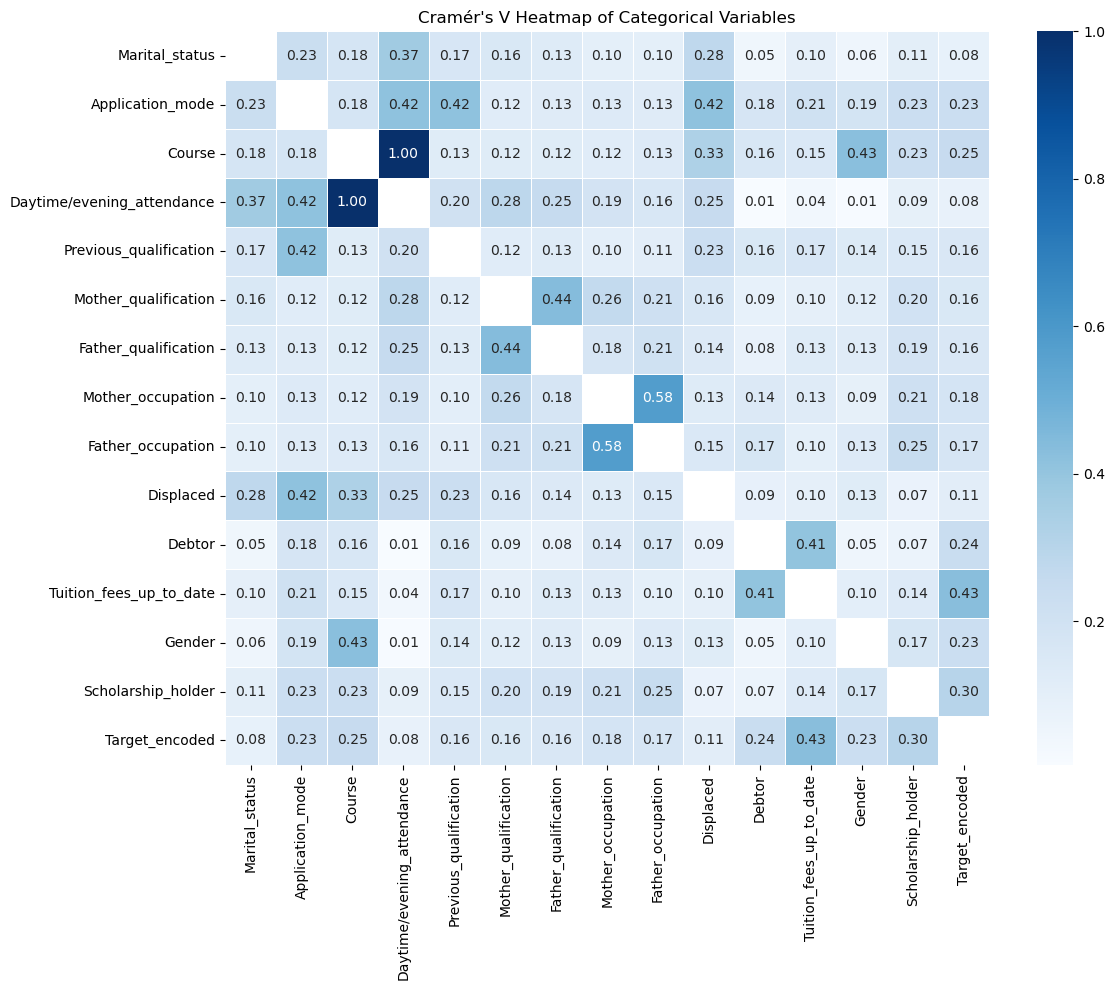

In [27]:
significant_vars = stud_selected.select_dtypes(include=['category']).columns.tolist()

# Crea matrice vuota
cramers_matrix = pd.DataFrame(index=significant_vars, columns=significant_vars)

# Calcola Cramér's V per ogni coppia
for var1, var2 in combinations(significant_vars, 2):
    v = cramers_v(stud_selected[var1], stud_selected[var2])
    cramers_matrix.loc[var1, var2] = v
    cramers_matrix.loc[var2, var1] = v

# Riempi la diagonale con 1
np.fill_diagonal(cramers_matrix.values.astype(float), 1.0)

# Converte tutto in float
cramers_matrix = cramers_matrix.astype(float)

# Plot della heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_matrix, annot=True, fmt=".2f", cmap='Blues', linewidths=0.5)
plt.title("Cramér's V Heatmap of Categorical Variables")
plt.tight_layout()
plt.show()

Add new feature: *Financial status*

In [28]:
def financial_status(row):
    if row['Tuition_fees_up_to_date'] == 1 and row['Debtor'] == 0:
        return 'Ok'
    elif row['Tuition_fees_up_to_date'] == 0 and row['Debtor'] == 1:
        return 'At Risk'
    else:
        return 'Moderate'

stud_selected['Financial_status'] = stud_selected.apply(financial_status, axis=1)
stud_selected['Financial_status'].value_counts()

# Drop the original columns
stud_selected.drop(['Tuition_fees_up_to_date', 'Debtor'], axis=1, inplace=True)

In [29]:
stud_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 33 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Marital_status                                4424 non-null   category
 1   Application_mode                              4424 non-null   category
 2   Application_order                             4424 non-null   int64   
 3   Course                                        4424 non-null   category
 4   Daytime/evening_attendance                    4424 non-null   category
 5   Previous_qualification                        4424 non-null   category
 6   Previous_qualification_grade                  4424 non-null   float64 
 7   Mother_qualification                          4424 non-null   category
 8   Father_qualification                          4424 non-null   category
 9   Mother_occupation                             4424 n

## Numerical features

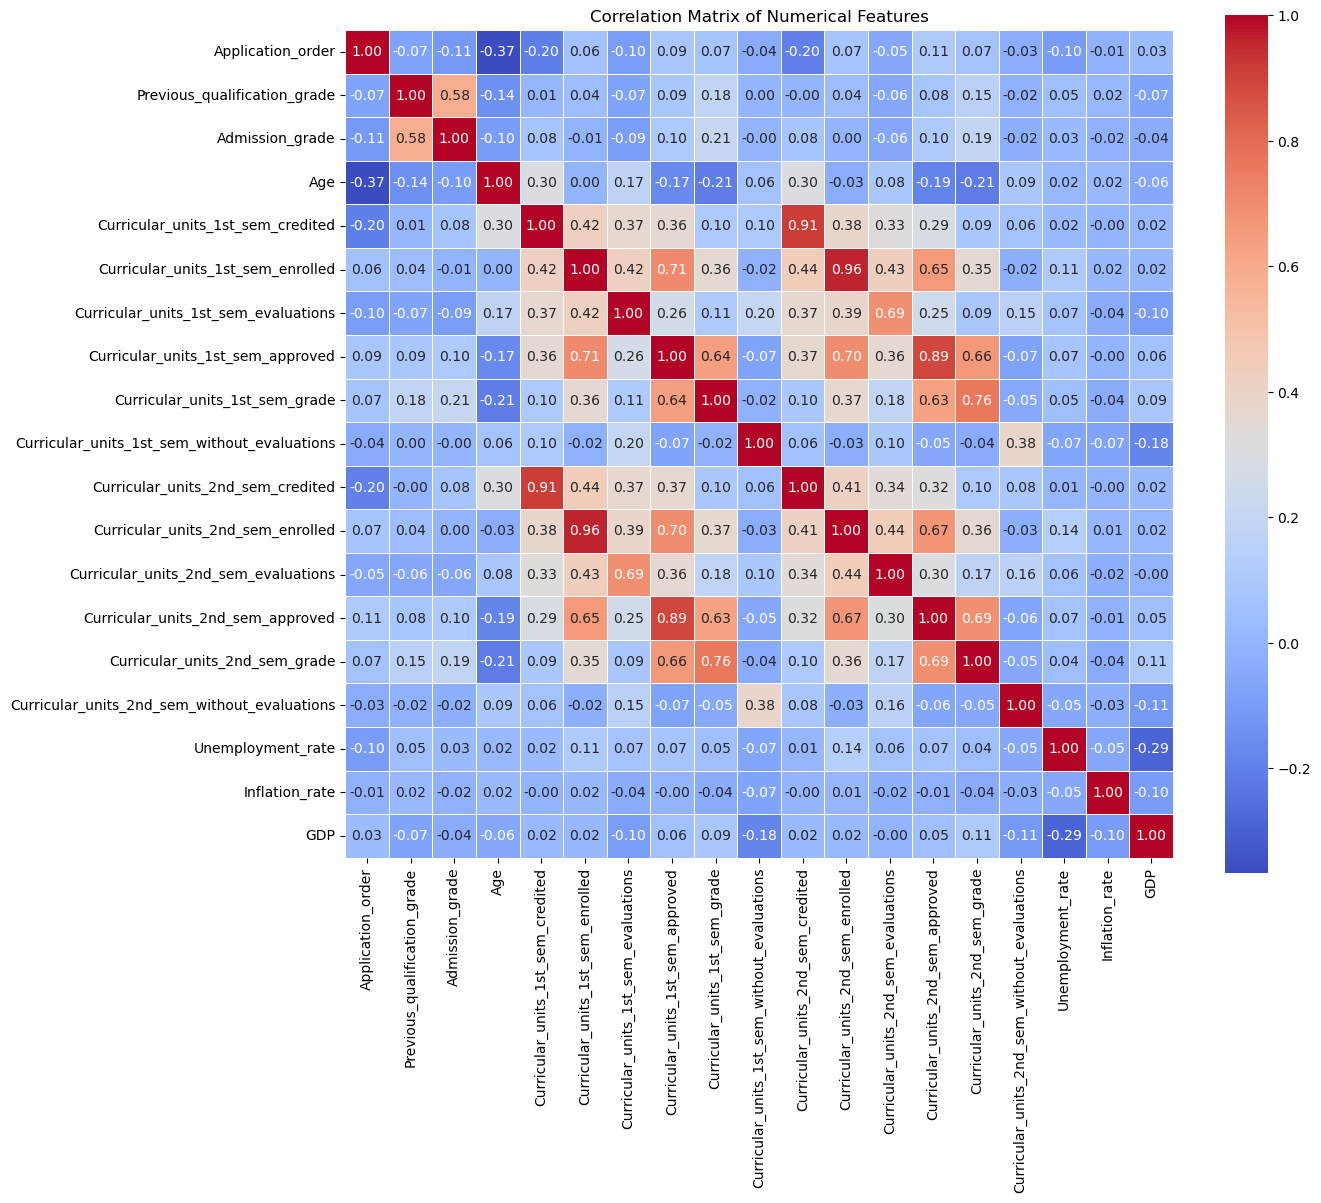

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleziona solo le colonne numeriche
numeric_cols = stud_selected.select_dtypes(include=['int64', 'float64']).columns

# Calcola la matrice di correlazione (metodo di default = Pearson)
corr_matrix = stud_selected[numeric_cols].corr(method='spearman')

# Visualizza la heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


In [44]:
# Averaging academic performance data across two semesters
stud_selected['avg_credited'] = stud_selected[['Curricular_units_1st_sem_credited','Curricular_units_2nd_sem_credited']].mean(axis = 1)

stud_selected['avg_enrolled'] = stud_selected[['Curricular_units_1st_sem_enrolled','Curricular_units_2nd_sem_enrolled']].mean(axis = 1)

stud_selected['avg_evaluations'] = stud_selected[['Curricular_units_1st_sem_evaluations','Curricular_units_2nd_sem_evaluations']].mean(axis = 1)

stud_selected['avg_approved'] = stud_selected[['Curricular_units_1st_sem_approved','Curricular_units_2nd_sem_approved']].mean(axis = 1)

stud_selected['avg_grade'] = stud_selected[['Curricular_units_1st_sem_grade','Curricular_units_2nd_sem_grade']].mean(axis = 1)

stud_selected['avg_without_evaluations'] = stud_selected[['Curricular_units_1st_sem_without_evaluations','Curricular_units_2nd_sem_without_evaluations']].mean(axis = 1)

stud_selected['approval_rate'] = stud_selected['avg_approved'] / stud_selected['avg_evaluations'].replace(0, 1)


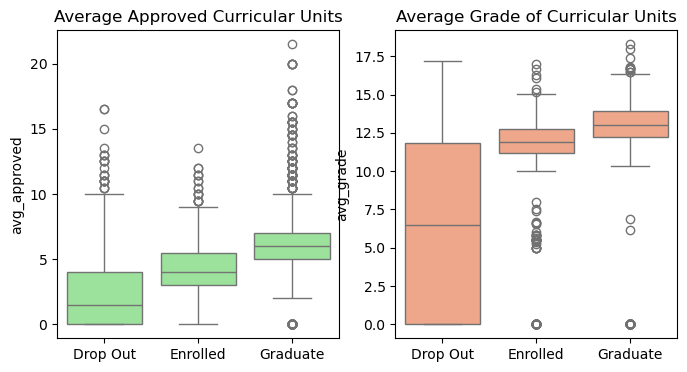

In [38]:
# Plot 'avg_approved' and 'avg_grade' vs. Target
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
sns.boxplot(data = stud_selected, x = 'Target_encoded', y = 'avg_approved', 
            color = 'lightgreen', ax = ax1)
ax1.set_title('Average Approved Curricular Units')
ax1.set_xlabel("")
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Drop Out', 'Enrolled', 'Graduate']);

sns.boxplot(data = stud_selected, x = 'Target_encoded', y = 'avg_grade', 
            color = 'lightsalmon', ax = ax2)
ax2.set_title('Average Grade of Curricular Units')
ax2.set_xlabel("")
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Drop Out', 'Enrolled', 'Graduate']);

In [45]:
# Drop unselected features along with the features that have been aggregated into new ones 
stud_selected = stud_selected.drop(columns = ['Curricular_units_1st_sem_credited', 
                                              'Curricular_units_1st_sem_enrolled', 
                                              'Curricular_units_1st_sem_evaluations', 
                                              'Curricular_units_1st_sem_approved', 
                                              'Curricular_units_1st_sem_grade', 
                                              'Curricular_units_1st_sem_without_evaluations', 
                                              'Curricular_units_2nd_sem_credited', 
                                              'Curricular_units_2nd_sem_enrolled', 
                                              'Curricular_units_2nd_sem_evaluations', 
                                              'Curricular_units_2nd_sem_approved', 
                                              'Curricular_units_2nd_sem_grade', 
                                              'Curricular_units_2nd_sem_without_evaluations'])

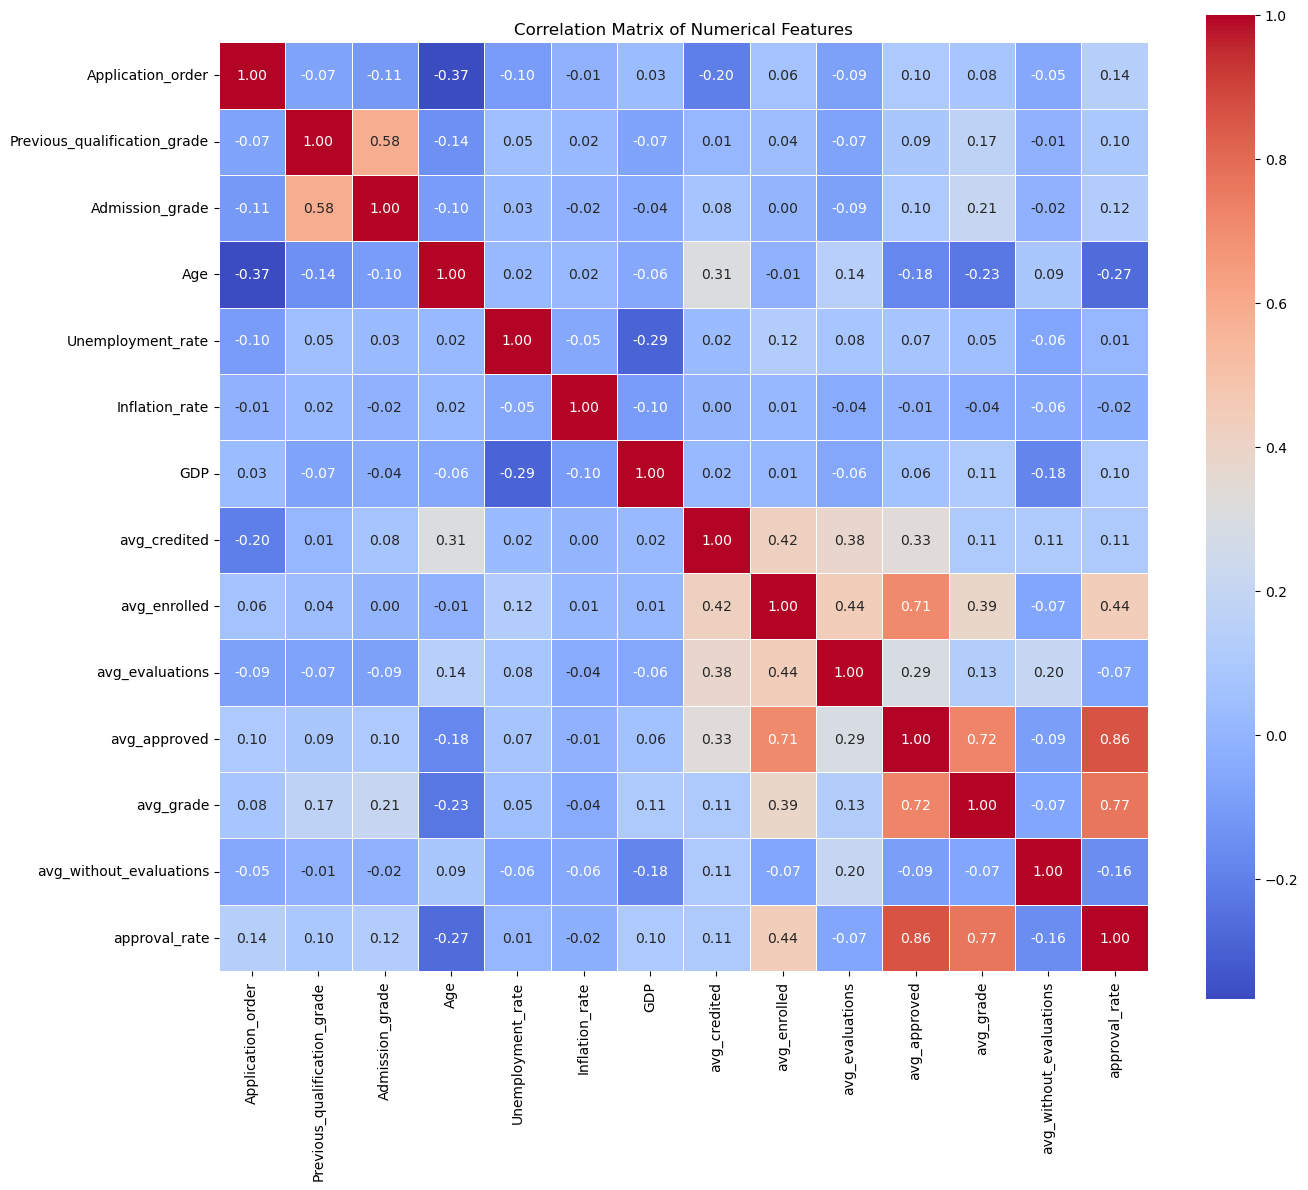

In [46]:
# Seleziona solo le colonne numeriche
numeric_cols = stud_selected.select_dtypes(include=['int64', 'float64']).columns

# Calcola la matrice di correlazione (metodo di default = Pearson)
corr_matrix = stud_selected[numeric_cols].corr(method='spearman')

# Visualizza la heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()